In [1]:
from ADMCode import visualize as vis
from ADMCode import qlearn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Q-learning

### Equations
---
* **Q-update**: $$Q(a_i) \leftarrow  Q(a_i) + \alpha (r_t - Q(a_i))$$

* **Softmax policy**: $$P(a_i) = \frac{e^{\beta Q(a_i)}}{\sum_j^N e^{\beta Q(a_j)}}$$

### Multi-armed bandit task

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url='https://github.com/CoAxLab/AdaptiveDecisionMaking_2018/blob/master/notebooks/images/bandit.png?raw=true', width=300, retina=True)

### Q-agent

In [3]:
# alpha (float):  learning rate parameter
# beta (float):   inverse temperature parameter 
# preward (list): 1xN vector of P(r) for each bandit
# rvalues (list): 1xN vector of rew. values for each bandit
agent = qlearn.Qagent(alpha=.12,
                      beta=2.5, 
                      preward=[.85, .75, .65], 
                      rvalues=[1, 1, 1])

### Simulate a single agent

In [25]:
# play 500 trials of multi-armed bandit task
data1 = agent.play_bandits(ntrials=500, get_output=True)

### Check output dataframe

In [26]:
#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
data1.head() 

,trial,q0,q1,q2,p0,p1,p2,choice,feedback
0,1,0.0000,0.1200,0.0,0.2985,0.4030,0.2985,1,1
1,2,0.1200,0.1200,0.0,0.3649,0.3649,0.2703,0,1
2,3,0.1056,0.1200,0.0,0.3566,0.3696,0.2738,0,0
3,4,0.1056,0.2256,0.0,0.3207,0.4329,0.2463,1,1
4,5,0.2129,0.2256,0.0,0.3818,0.3941,0.2242,0,1


### Plot $Q \, \& \, P$ values $(\alpha=.12)$

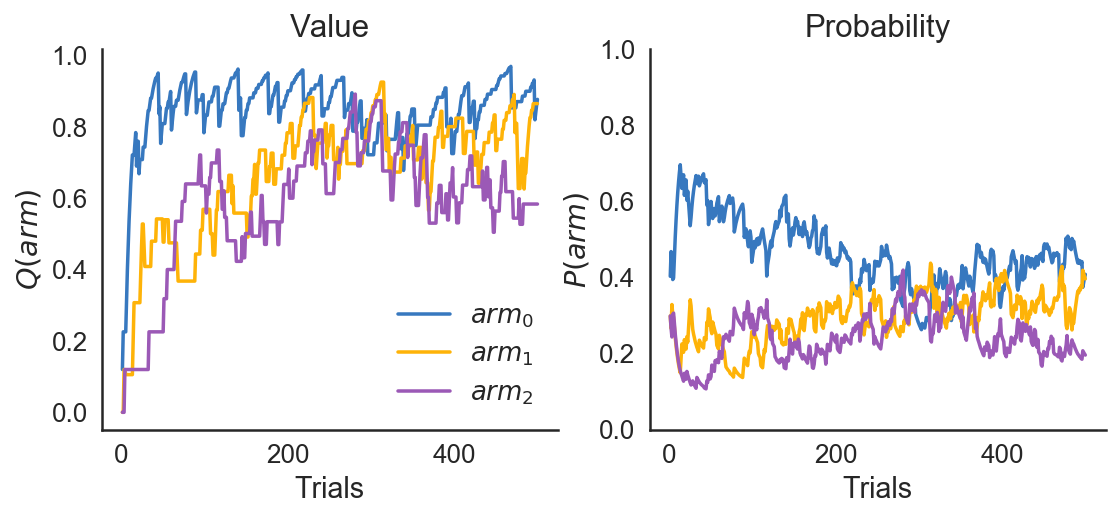

In [22]:
# plot Q-values and softmax selection prob. for each bandit
vis.plot_qlearning(data1)

### Re-simulate agent with $\alpha=.025$

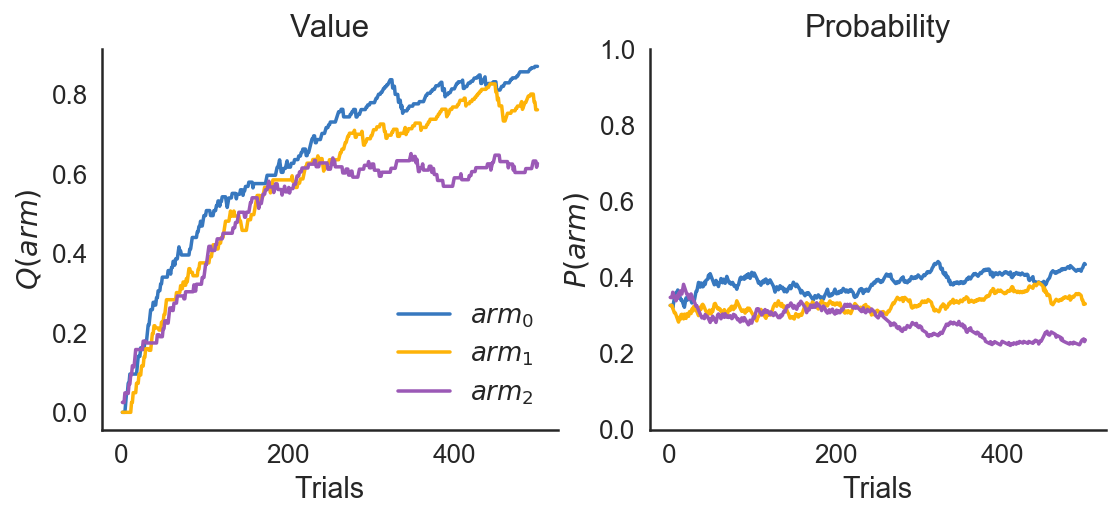

In [8]:
agent.set_agent_params(alpha=.025)
data2 = agent.play_bandits(ntrials=500, get_output=True)
vis.plot_qlearning(data2)

### Simulate multiple agents

In [9]:
# simulate N=10 agents (500 trials each), with alpha=.12
agent.set_agent_params(alpha=.12)
data3 = agent.simulate_multiple_agents(nagents=10, ntrials=500)

# simulate N=10 agents (500 trials each), with alpha=.025
agent.set_agent_params(alpha=.025)
data4 = agent.simulate_multiple_agents(nagents=10, ntrials=500)

#### $\alpha = .12$

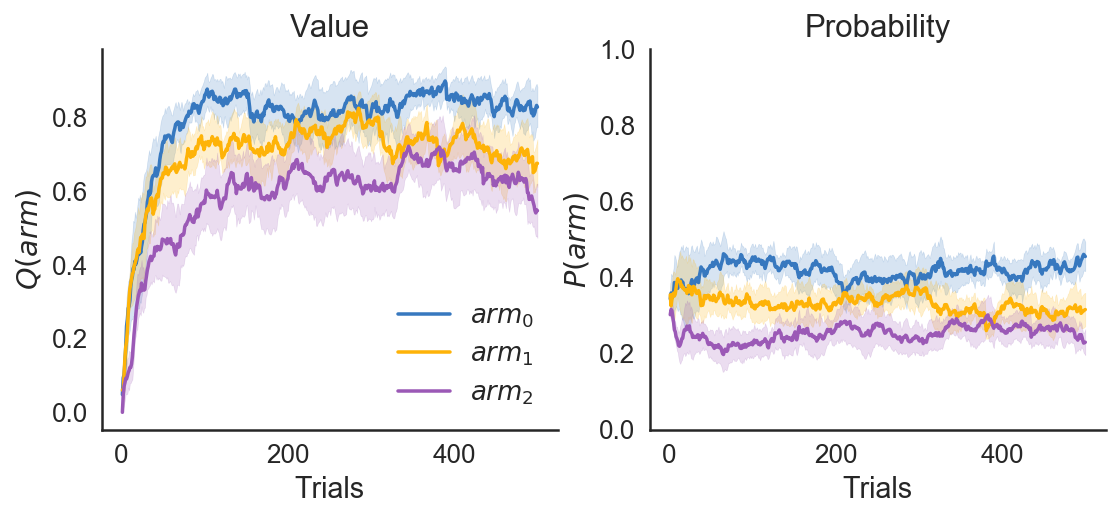

In [10]:
vis.plot_qlearning(data3)

#### $\alpha = .025$

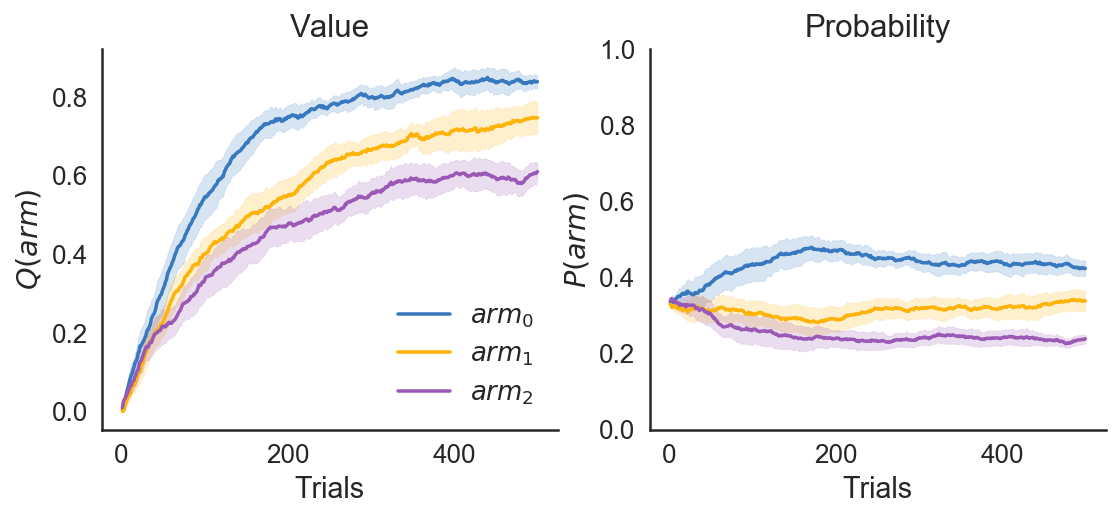

In [11]:
vis.plot_qlearning(data4)

# Q-learning code

In [40]:
def update_Qi(Qval, reward, alpha):
    """ update q-value of selected action, given reward and alpha
    """
    return Qval + alpha*(reward - Qval)

def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """
    return np.array([np.exp(beta*Q_i) / np.sum(np.exp(beta * Qvector)) for Q_i in Qvector])

In [41]:
def play_bandits(alpha=.1, beta=.15, preward=[.8, .5, .2], ntrials=1000):
    """ 
    ::Arguments::
        alpha (float): learning rate
        beta (float): inverse temperature parameter
        preward (list): 1xN vector of P(reward) for each of N bandits
        ntrials (int): number of trials to play bandits
    ::Returns::
        pandasDF (Ntrials x Nbandits), trialwise Q/P values per bandit
    """
    nact = len(preward)
    actions = np.arange(nact)  
    rvalues = np.ones(nact)
    
    bandits = qlearn.MultiArmedBandit(preward=preward, rvalues=rvalues)
    
    Qmatrix=np.zeros((ntrials, nact))
    Pmatrix=np.zeros_like(Qmatrix)
    Qvalues = Qmatrix[0, :]
    Pvalues = np.array([1/nact]*nact)

    for t in range(ntrials):
        # select bandit arm (action)
        act_i = np.random.choice(actions, p=Pvalues)
        
        # observe feedback
        r = bandits.get_feedback(act_i)
        # get expected value 
        Qexpected = Qvalues[act_i]
        # update expected value and store in Qvalues array
        # Qexpected + alpha * (r - Qexpected)
        Qvalues[act_i] = update_Qi(Qexpected, r, alpha)
        
        # update action selection probabilities 
        Pvalues = update_Pall(Qvalues, beta)
        
        # store new values in output matrices
        Qmatrix[t, :] = Qvalues
        Pmatrix[t, :] = Pvalues
        
    return make_output_df(Qmatrix, Pmatrix)  

In [42]:
def make_output_df(Qmatrix, Pmatrix):
    """ generate output dataframe with trialwise Q and P measures for each bandit,
    as well as choice selection, and feedback
    ::Arguments::
        Qmatrix (ndarray): q-value array with dims [Ntrials x Nbandits] 
        Pmatrix (ndarray): softmax prob array with dims [Ntrials x Nbandits] 
    ::Returns::
        df (DataFrame): pandas df containing Q and P values for each bandit [Ntrials x 2*Nbandits]
    """
    actions = np.arange(Qmatrix.shape[1])
    df = pd.concat([pd.DataFrame(dat) for dat in [Qmatrix, Pmatrix]], axis=1)
    cols = [['{}{}'.format(x,c) for c in actions] for x in ['q', 'p']]
    df.columns = np.hstack(cols)
    df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
    return df

In [43]:
df = play_bandits(alpha=.1, beta=2, preward=[.85, .75, .65])

In [44]:
df.head()

,trial,q0,q1,q2,p0,p1,p2
0,1,0.8013,0.6865,0.6183,0.3104,0.3792,0.3104
1,2,0.1000,0.1000,0.0000,0.3548,0.3548,0.2905
2,3,0.1000,0.1900,0.0000,0.3316,0.3970,0.2715
3,4,0.1900,0.1900,0.0000,0.3726,0.3726,0.2548
4,5,0.1710,0.1900,0.0000,0.3638,0.3778,0.2584


In [49]:
from ADMCode import style_notebook
style_notebook()